# SAO/LIP Python Primer Course Lecture 8

In this notebook, you will learn about:
- The `scipy` library
- Integration
- Optimization
- Advanced linear algebra

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/acorreia61201/SAOPythonPrimer/blob/main/lectures/Lecture8.ipynb)

## The `scipy` Library

We've covered `numpy`, which is a powerful library in its own right. However, there are some common mathematical problems that would be convenient to have on-hand when doing scientific programming. The `scipy` library is designed specifically for this. It builds upon the functionality of `numpy` to include hundreds of functions that span the breadth of mathematics. Talking about every single thing that you can do with `scipy` would take a summer in itself, so for now we'll cover some of the most notable functionalities of the library.

Of course, the first thing we have to do is make sure it's installed:

In [1]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import scipy

There's so much you can do with `scipy` that it's often more convenient to import individual sublibraries. We'll do this at the start of each relevant section.

## Integration

Differential equations are used throughout STEM to model a variety of problems. The most common way to solve these are with integration, which can be tricky to implement programmatically (as you've probably seen in the exercises). `scipy` has an entire sublibrary `integrate` which provides various integration functions:

In [3]:
from scipy import integrate

To start, `scipy` has some basic numerical integrators for computing definite integrals. We've seen some examples of this in the trapezoidal rule and Monte-Carlo method from the exercise sets. To evaluate integrals, we can use the function `scipy.integrate.quad()`, which takes in a function and the bounds as three arguments.

For example, let's evaluate the following using `integrate.quad()`:

\begin{equation}
\int_0^1 x^2 dx
\end{equation}

Using basic calculus, we know that the above integral has an exact value of $[x^3/3]_0^1 = 1/3$. Let's use `scipy` to verify this:

In [5]:
def func(x):
    return x*x

a, b = (0, 1) # bounds of integration
result = integrate.quad(func, a, b)
result

(0.33333333333333337, 3.700743415417189e-15)

We can see that `integrate.quad()` returns a tuple. The first element is the value of the integral, while the second element is an estimate of the absolute error.

We can also input functions with parameters. For example, let's say I instead wanted to integrate:

\begin{equation}
\int_0^1 ax^2 dx
\end{equation}

Here, $a$ is a parameter independent of $x$. Therefore, we can pull out the constant to get a result of $a/3$. To do this with `integrate.quad()`, we can pass the keyword argument `args` to give extra arguments to the function besides $x$. Let's try integrating with a variety of $a$ values:

In [15]:
def afunc(x, a):
    return a*x*x

a, b = (0, 1)
integrate.quad(afunc, a, b, args=(1,)) # a = 1

(0.33333333333333337, 3.700743415417189e-15)

In [16]:
integrate.quad(afunc, a, b, args=(3,)) # a = 3

(1.0, 1.1102230246251565e-14)

Notice that if we want to integrate in this way, we have to put the variable of integration first and all parameters afterward.

If we want to integrate to $+ \infty$ or $- \infty$, we can use `numpy.inf` in place of one or both of the bounds. For example, let's take the following integral:

\begin{equation}
\int_{-\infty}^{+\infty} e^{-x^2} dx
\end{equation}

Using non-elementary methods, we can evaluate this integral as $\sqrt{\pi}$. Let's verify this using `scipy`:

In [17]:
import numpy as np

def norm(x):
    return np.exp(-x*x)

integrate.quad(norm, -np.inf, np.inf)

(1.7724538509055159, 1.4202636780944923e-08)

In [18]:
np.sqrt(np.pi)

1.7724538509055159

As promised, we can also use this to solve systems of ordinary differential equations. Let's use the simple example of an object in freefall. In physics, we define the velocity and acceleration of an object as:

\begin{align}
\frac{dx}{dt} &= v \\
\frac{d^2x}{dt^2} &= g
\end{align}

We'll use $g = -9.81 m/s^2$, the acceleration due to gravity on Earth, as our constant acceleration. We can rewrite the second equation into a system of two first-order equations by substituting the first equation:

\begin{align}
\frac{dx}{dt} &= v \\
\frac{dv}{dt} &= g
\end{align}

If we know the constant value of $a$ along with the initial position and velocity, we have an *initial-value problem*, or *IVP*, that describes the one-dimensional motion of an object. We can rewrite this as a matrix equation as we would a regular linear system of equations to get:

\begin{equation}
\frac{d\textbf{x}}{dt} =
\begin{bmatrix}
dx/dt \\
dv/dt \\
\end{bmatrix} =
\begin{bmatrix}
v \\
g \\
\end{bmatrix}
\end{equation}

To input this into `scipy`, we need a function that takes in the vector $\textbf{x} = [x, v]$ and outputs the results $[v, g]$. We can do so as follows:

In [19]:
# initial conditions
g = -9.81 # gravitational acceleration
x0_0 = 0 # initial position
x0_1 = 0 # initial velocity
x0 = [x0_0, x0_1] # initial conditions vector

def freefall(t, x): # x is a vector of the form [x, v]
    return [x[1], g] # return vector [v, g]

Now, we can use the function `integrate.solve_ivp()` to solve this equation over an array of $t$ values:

In [43]:
t = [0, 10] # start and end points of integration
soln = integrate.solve_ivp(freefall, t, x0)
soln

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-04  1.100e-03  1.110e-02  1.111e-01
             1.111e+00  1.000e+01]
        y: [[ 0.000e+00 -4.905e-08 ... -6.055e+00 -4.905e+02]
            [ 0.000e+00 -9.810e-04 ... -1.090e+01 -9.810e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 38
     njev: 0
      nlu: 0

The output of produces two arrays representing the values of time and our $x$ vector. We can call these individually using the methods `soln.t` and `soln.y`

In [44]:
times = soln.t
positions = soln.y[0,:]
velocities = soln.y[1,:]

Let's plot them to see how it did. We'll compare against the analytic results:

\begin{align}
x(t) &= x_0 + v_0t + \frac{1}{2}gt^2 \\
v(t) &= v_0 + gt
\end{align}

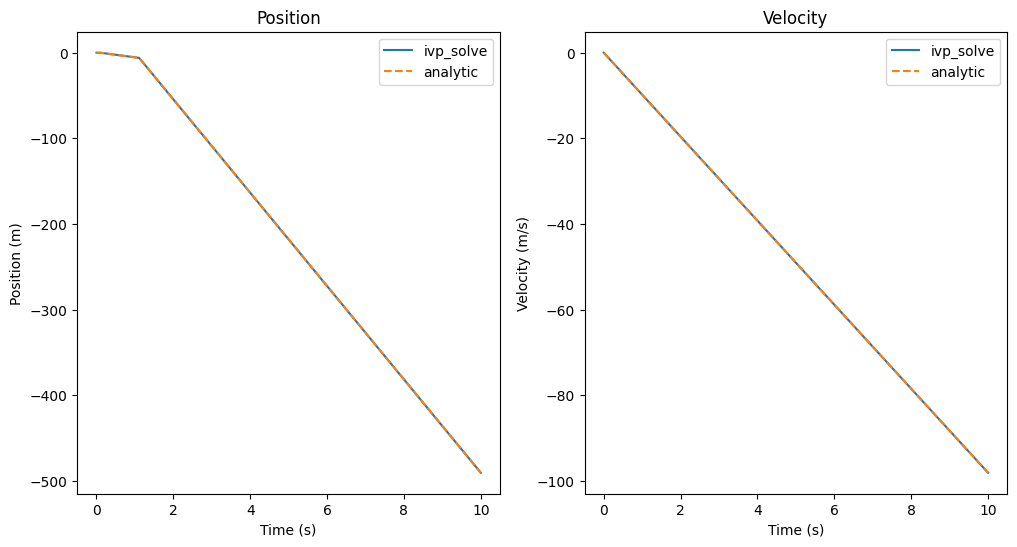

In [45]:
import matplotlib.pyplot as plt

ana_pos = [0.5*g*i*i for i in times] # analytic positions
ana_vel = [g*i for i in times] # analytic velocities

def plotter():
    '''
    A function to plot the outputs so we don't have to copy later.

    You can use functions with no input or output to run verbose sections of code
    like this as much as you'd like.
    '''
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(times, positions, label='ivp_solve')
    ax[0].plot(times, ana_pos, linestyle='--', label='analytic')
    ax[0].set_title('Position')
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Position (m)')
    ax[0].legend()

    ax[1].plot(times, velocities, label='ivp_solve')
    ax[1].plot(times, ana_vel, linestyle='--', label='analytic')
    ax[1].set_title('Velocity')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Velocity (m/s)')
    ax[1].legend()

plotter()

We can see that the plots are very coarse-grained; the left plot looks nothing like the parabolic behavior we'd expect. `solve_ivp` automatically determines the *step size* over which to integrate. This is an optimization protocol that skips over low-detail areas to minimize runtime, but comes with the downside of potentially obscuring the shape of the function as we see here. We can control this with the keyword argument `max_step`, which determinines the maximum step size allowed by the solver. We can set it to something small to capture as much detail as possible, like 0.05 seconds:

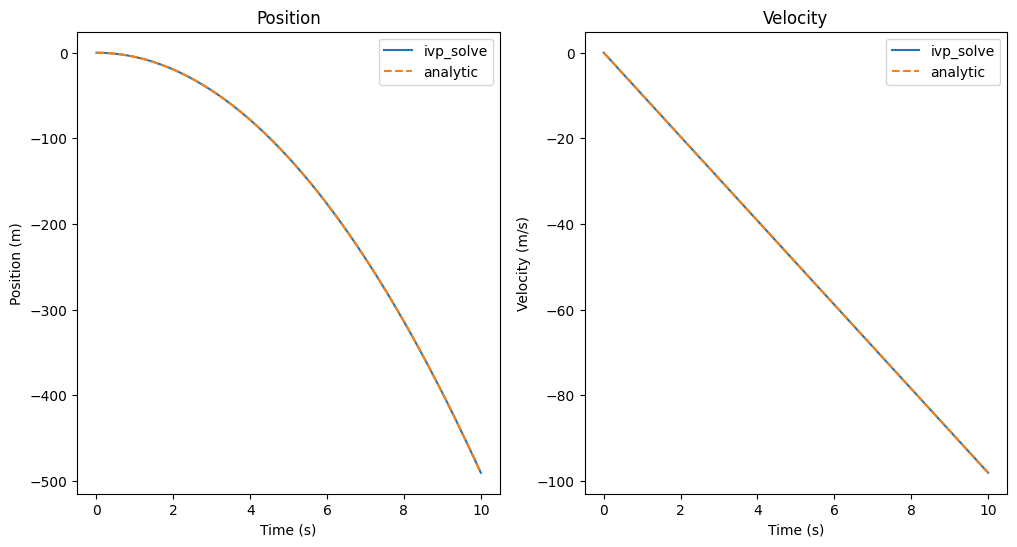

In [46]:
soln = integrate.solve_ivp(freefall, t, x0, max_step = 0.05) # integrate every 0.05 seconds
times = soln.t
positions = soln.y[0,:]
velocities = soln.y[1,:]
ana_pos = [0.5*g*i*i for i in times] # analytic positions
ana_vel = [g*i for i in times] # analytic velocities
plotter()

That's more like it. We can see that the solver does a pretty good job at matching our expectations. If you're curious, `ivp_solve` uses an integration algorithm called *RK45*, one of the best algorithms for balancing performance and accuracy. You can use a keyword `method` to use a different solver of your choice.

## Optimization

Another common problem in data analysis is *optimization*, which revolves around finding the maxima, minima, and zeroes of various functions. In `scipy`, these functions are grouped under the `optimize` sublibrary, which we'll call below:

In [47]:
from scipy import optimize

Let's start with finding zeroes, also known as *root-finding*. The function `scipy.optimize.root()` can be used for this. Let's use it to estimate the root of the following equation:

\begin{equation}
5xe^x - 5 = 0
\end{equation}

(This is related to the *Lambert W function*, an important function in statistics.) This is a *transcendental function*, meaning it cannot be expressed in terms of elementary functions and there's no analytic way to find its root. We can, however, use `scipy` to do it for us. All we need is the function representation of this equation and an initial guess to where the zero is:

In [49]:
def lambw(x):
    return 5*x*np.exp(x) - 5

zero = optimize.root(lambw, 0.5) # guess that the zero is at 0.5
zero

 message: The solution converged.
 success: True
  status: 1
     fun: [-1.776e-15]
       x: [ 5.671e-01]
    nfev: 7
    fjac: [[-1.000e+00]]
       r: [-1.382e+01]
     qtf: [-1.707e-09]

We can see from the output that the convergence was a success. From this, we can see the `x` value at which the root is located as well as the value of the function `fun` at that `x` value. We can call these with attributes, just as before:

In [50]:
zero.fun

array([-1.77635684e-15])

In [51]:
zero.x

array([0.56714329])

To check that it worked, we can plot the function as well as the calculated zero point:

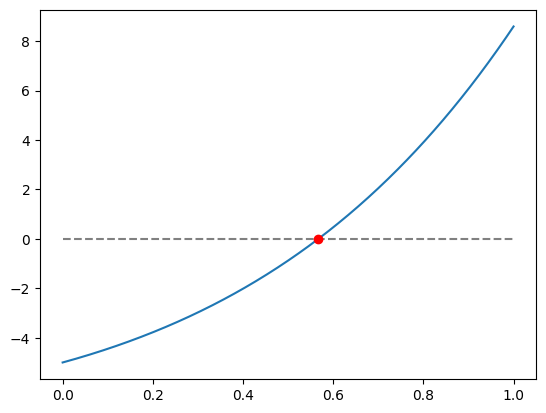

In [54]:
x_vals = np.linspace(0, 1, 500)
plt.plot(x_vals, lambw(x_vals)) # function
plt.plot(x_vals, [0 for i in x_vals], linestyle='--', color='grey') # x-axis
plt.plot(zero.x, zero.fun, 'ro') # zero of the function, as a red circle

For functions with multiple roots, the solver will attempt to find the root closest to your guess. Let's try with a function with multiple roots:

\begin{equation}
6x^2 - x - 35 = 0
\end{equation}

Using the quadratic formula, we can calculate the analytic zeroes $x=(5/2, -7/3)$. Let's try a guess closer to the smaller root:

In [56]:
def func(x):
    return 6*x*x - x - 35

root1 = optimize.root(func, -2)
root1

 message: The solution converged.
 success: True
  status: 1
     fun: [-2.771e-13]
       x: [-2.333e+00]
    nfev: 7
    fjac: [[-1.000e+00]]
       r: [ 2.900e+01]
     qtf: [-1.271e-07]

And now a guess closer to the other root:

In [57]:
root2 = optimize.root(func, 2)
root2

 message: The solution converged.
 success: True
  status: 1
     fun: [ 0.000e+00]
       x: [ 2.500e+00]
    nfev: 8
    fjac: [[-1.000e+00]]
       r: [-2.900e+01]
     qtf: [ 9.008e-11]

Being ludicrously off shouldn't cause too much trouble for well behaved functions like a quadratic; it will just take longer. However, you do run the risk of the solver taking so long that it can't converge.

In [60]:
root3 = optimize.root(func, 1000)
root3

 message: The solution converged.
 success: True
  status: 1
     fun: [ 8.811e-13]
       x: [ 2.500e+00]
    nfev: 20
    fjac: [[-1.000e+00]]
       r: [-2.900e+01]
     qtf: [-2.342e-07]

In [61]:
root4 = optimize.root(func, 10**10)
root4

 message: The solution converged.
 success: True
  status: 1
     fun: [ 0.000e+00]
       x: [ 2.500e+00]
    nfev: 54
    fjac: [[-1.000e+00]]
       r: [-2.900e+01]
     qtf: [-9.017e-10]

There's also a method of minimizing functions in `scipy` using `optimize.minimize()`. Let's try to find the vertex of the parabola from the last example. Again, we need a guess as to where the vertex is, which doesn't have to be that accurate:

In [62]:
vertex = optimize.minimize(func, 0)
vertex

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -35.041666666666664
        x: [ 8.333e-02]
      nit: 1
      jac: [ 0.000e+00]
 hess_inv: [[1]]
     nfev: 6
     njev: 3

This output shows the value `x` at which the minimum occurs as well as the y-value `func` at that `x` value. Again, we can verify this visually by plotting:

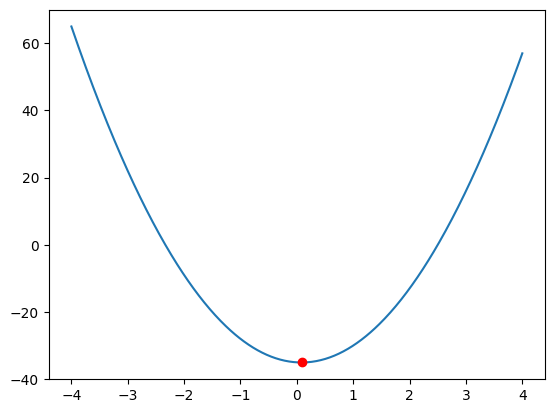

In [64]:
x_vals = np.linspace(-4, 4, 500)
plt.plot(x_vals, func(x_vals)) # the parabola
plt.plot(vertex.x, vertex.fun, 'ro') # the minimum value, 

Both `root` and `minimize` have additional methods of solving accessible with the `method` keyword, viewable in each function's respective docs.

## Linear Algebra

`scipy` also has a robust linear algebra library that builds upon the functionality of `numpy`. We can import it down below:

In [65]:
from scipy import linalg

This library contains a lot of more specialized operations that are nonetheless widely-used throughout linear algebra and data science. One of these operations is *inversion*, which we've seen a little bit in the exercises. There, we only considered the inverses of 2x2 matrices; for larger matrices exact formulas become exponentially less tractible. Fortunately, we can use `scipy.linalg.inv()` to easily compute the inverse of any matrix:

In [66]:
import numpy as np

A = np.array([[1, 3, 5], [2, 5, 1], [2, 3, 8]])
A

array([[1, 3, 5],
       [2, 5, 1],
       [2, 3, 8]])

In [67]:
Ainv = linalg.inv(A)
Ainv

array([[-1.48,  0.36,  0.88],
       [ 0.56,  0.08, -0.36],
       [ 0.16, -0.12,  0.04]])

We can check that this is correct using `numpy.matmul`; we should get back the identity matrix:

In [72]:
np.matmul(A, Ainv)

array([[ 1.00000000e+00, -1.11022302e-16,  4.85722573e-17],
       [ 3.05311332e-16,  1.00000000e+00,  7.63278329e-17],
       [ 2.22044605e-16, -1.11022302e-16,  1.00000000e+00]])

It's a bit harder to see with the floating-point errors, but we get the identity matrix as expected. (You can also check by hand if you're still not convinced.)

One application that we saw for matrix inverses is for solving linear equations. `scipy` actually has a function `linalg.solve()` designed just for this. Let's now say I wanted to solve the following system using `A` as defined above:

\begin{align}
x + 3y + 5z &= 10 \\
2x + 5y + z &= 8 \\
2x + 3y + 8z &= 3
\end{align}

We can write this as a matrix equation by casting the right-hand side of each equation in a column vector:

In [73]:
b = np.array([[10], [8], [3]])
b

array([[10],
       [ 8],
       [ 3]])

In [74]:
linalg.solve(A, b)

array([[-9.28],
       [ 5.16],
       [ 0.76]])

This is the exact same result we'd get if we used the matrix inverse method (i.e. multiplying both sides of the equation by the matrix inverse), except the code under the hood of `solve()` is faster more numerically stable:

In [75]:
np.dot(Ainv, b)

array([[-9.28],
       [ 5.16],
       [ 0.76]])

Another widely-used linear algebra quantity is the *determinant* of a matrix, which we saw when manually computing matrix inverses. We can use `scipy.linalg.det()` to compute determinants quickly and easily:

In [76]:
linalg.det(A)

-25.000000000000004

(Again, you may work this out analytically if you're not convinced.)

A concept more useful to applied sciences like physics is the calculation of *eigenvalues* and *eigenvectors*. These are values that satisfy the following equation:

\begin{equation}
Av = \lambda v
\end{equation}

Here, $\lambda$ is an eigenvalue of $A$, and $v$ is an eigenvector of $A$. In other words, the eigenvectors $v$ of a matrix are vectors that, when multiplied by that matrix, are proportional to themselves up to a factor of their respective eigenvalue. To solve the above equation by-hand, we could move all terms to the left side, multiply by the identity matrix $I$, and recognize that $v$ is a general non-zero vector to get:

\begin{equation}
\det(A - \lambda I) = 0
\end{equation}

We can then solve a polynomial of order $N$ for an $N \times N$ matrix to get the eigenvalues. Then, we can plug these values into the first equation and solve for the eigenvectors $v$. Alternatively, a much faster approach would be to use `scipy.linalg.eig()` to calculate the eigenvalues and eigenvectors of $A$:

In [77]:
linalg.eig(A)

(array([10.5540456 +0.j, -0.5873064 +0.j,  4.03326081+0.j]),
 array([[-0.51686204, -0.94195144,  0.11527992],
        [-0.32845853,  0.31778071, -0.81936883],
        [-0.79054957,  0.10836468,  0.56155611]]))

This gives us a tuple of two arrays. The first array contains the eigenvalues, and the second contains the eigenvectors. We can parse through them individually by indexing as we would any other array:

In [79]:
vals, vecs = linalg.eig(A)
print(vals[0])
print(vals[1])
print(vals[2])

(10.5540455960959+0j)
[-0.51686204 -0.94195144  0.11527992]


(The `j` term in each eigenvalue represents the imaginary part of the results. If you're unfamiliar with complex numbers, don't worry; everything we'll be doing here should only involve real numbers.)

Take care when calling the eigenvectors, though; they're saved as column vectors, so we'll have to call them as we would columns from a matrix:

In [88]:
print(vecs[:,0])
print(vecs[:,1])
print(vecs[:,2])

[-0.51686204 -0.32845853 -0.79054957]
[-0.94195144  0.31778071  0.10836468]
[ 0.11527992 -0.81936883  0.56155611]



We can verify these results by checking the above two equations:

In [82]:
linalg.det(A - np.eye(3,3)*vals[0])

(-2.926061473787121e-13+0j)

In [90]:
print(np.matmul(A, vecs[:,0]))
print(vals[0]*vecs[:,0])

[-5.4549855  -3.46656629 -8.34349626]
[-5.4549855 +0.j -3.46656629+0.j -8.34349626+0.j]


As always, this is only an introduction to what can be done in `scipy`; I can say so from experience. This library has functionality for doing advanced statistics, interpolation in datasets, least-squares fitting to scatterplots, Fourier transforms, and even basic stochastic sampling such as Monte-Carlo. You can see everything you can do with `scipy`, including with the small sampling of functions I've shown here, at https://docs.scipy.org/doc/scipy/reference/index.html.